In [31]:
import sys
sys.path.append('..')

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from utils import SUBSET_LANGUAGES

plt.rcParams['font.family'] = 'P052'
plt.rcParams['font.serif'] = ['Times New Roman']

In [33]:
# Example usage with the new parameter
file_paths = {
    # ByT5
    "ByT5": 'eval_results/span_corruption_multilingual/T5/t5_span_corruption_multilingual_seed76.csv',
    # MrT5
    "MrT5,\nδ=0.3": 'eval_results/span_corruption_multilingual/MrT5/mrt5_span_corruption_multilingual_pi-cntrl30%_seed16.csv',
    "MrT5,\nδ=0.4": 'eval_results/span_corruption_multilingual/MrT5/mrt5_span_corruption_multilingual_pi-cntrl40%_seed53.csv',
    "MrT5,\nδ=0.5": 'eval_results/span_corruption_multilingual/MrT5/mrt5_span_corruption_multilingual_pi-cntrl50%_seed40.csv',
    "MrT5,\nδ=0.6": 'eval_results/span_corruption_multilingual/MrT5/mrt5_span_corruption_multilingual_pi-cntrl60%_seed67.csv',
    "MrT5,\nδ=0.7": 'eval_results/span_corruption_multilingual/MrT5/mrt5_span_corruption_multilingual_pi-cntrl70%_seed51.csv',
    # Random
    "Random, 30%": 'eval_results/span_corruption_multilingual/RandomT5/randomt5_span_corruption_multilingual_30%_seed54.csv',
    "Random, 40%": 'eval_results/span_corruption_multilingual/RandomT5/randomt5_span_corruption_multilingual_40%_seed65.csv',
    "Random, 50%": 'eval_results/span_corruption_multilingual/RandomT5/randomt5_span_corruption_multilingual_50%_seed109.csv',
    "Random, 60%": 'eval_results/span_corruption_multilingual/RandomT5/randomt5_span_corruption_multilingual_60%_seed86.csv',
    "Random, 70%": 'eval_results/span_corruption_multilingual/RandomT5/randomt5_span_corruption_multilingual_70%_seed595.csv',
    # Fixed
    "Fixed, 30%": 'eval_results/span_corruption_multilingual/FixedT5/fixedt5_span_corruption_multilingual_30%_seed102.csv',
    "Fixed, 40%": 'eval_results/span_corruption_multilingual/FixedT5/fixedt5_span_corruption_multilingual_40%_seed96.csv',
    "Fixed, 50%": 'eval_results/span_corruption_multilingual/FixedT5/fixedt5_span_corruption_multilingual_50%_seed432.csv',
    "Fixed, 60%": 'eval_results/span_corruption_multilingual/FixedT5/fixedt5_span_corruption_multilingual_60%_seed51.csv',
    "Fixed, 70%": 'eval_results/span_corruption_multilingual/FixedT5/fixedt5_span_corruption_multilingual_70%_seed234.csv',
    # BPT5
    "BP, p=0.7": 'eval_results/span_corruption_multilingual/BPT5/bpt5_span_corruption_multilingual_30%_seed462.csv',
    "BP, p=0.6": 'eval_results/span_corruption_multilingual/BPT5/bpt5_span_corruption_multilingual_40%_seed58.csv',
    "BP, p=0.5": 'eval_results/span_corruption_multilingual/BPT5/bpt5_span_corruption_multilingual_50%_seed91.csv',
    "BP, p=0.4": 'eval_results/span_corruption_multilingual/BPT5/bpt5_span_corruption_multilingual_60%_seed31.csv',
    "BP, p=0.3": 'eval_results/span_corruption_multilingual/BPT5/bpt5_span_corruption_multilingual_70%_seed13.csv',
    # Canine
    "CP, r=2": 'eval_results/span_corruption_multilingual/CanineT5/caninet5_span_corruption_multilingual_rate2_seed501.csv',
    "CP, r=3": 'eval_results/span_corruption_multilingual/CanineT5/caninet5_span_corruption_multilingual_rate3_seed121.csv',
    "CP, r=4": 'eval_results/span_corruption_multilingual/CanineT5/caninet5_span_corruption_multilingual_rate4_seed74.csv',
    
}

In [34]:
def extract_data_from_files(file_paths, column_name):
    # Create an empty dictionary to store the data
    data = {}
    
    # Read each CSV file and extract the specified column
    for i, (model_name, file_path) in enumerate(file_paths.items()):
        df = pd.read_csv(file_path)

        # First iteration, store the languages
        if i == 0:
            data['Language'] = list(df['Language'])

        # Next, store the model's values for the specified column
        data[model_name] = list(df.set_index('Language')[column_name])

    # Convert the dictionary to a DataFrame
    result_df = pd.DataFrame(data)

    # Adding the sample size column
    result_df["Sample Size"] = 10000  # Default sample size
    result_df.loc[result_df["Language"] == "Swahili", "Sample Size"] = 2816
    result_df.loc[result_df["Language"] == "Urdu", "Sample Size"] = 9328

    return result_df

In [35]:
losses_df = extract_data_from_files(file_paths, "Eval Cross Entropy Loss")
runtimes_df = extract_data_from_files(file_paths, "Eval Runtime")

## Runtime Analysis

In [43]:
# Compute the weighted mean for each numeric column
per_sample_average = runtimes_df.drop(columns=["Language", "Sample Size"]).sum() / runtimes_df["Sample Size"].sum()
per_sample_average = per_sample_average * 1000 # Convert to milliseconds
per_sample_average[:6]

ByT5            78.631273
MrT5,\nδ=0.3    64.584691
MrT5,\nδ=0.4    57.832572
MrT5,\nδ=0.5    56.019163
MrT5,\nδ=0.6    51.513597
MrT5,\nδ=0.7    47.046470
dtype: float64

In [44]:
byt5_runtime = per_sample_average["ByT5"]
# Compute percent decrease relative to ByT5
percent_decrease = (byt5_runtime - per_sample_average) / byt5_runtime * 100
percent_decrease[:6]

ByT5             0.000000
MrT5,\nδ=0.3    17.863862
MrT5,\nδ=0.4    26.450928
MrT5,\nδ=0.5    28.757146
MrT5,\nδ=0.6    34.487138
MrT5,\nδ=0.7    40.168246
dtype: float64

## Loss vs. Sequence Length Reduction

In [37]:
import numpy as np

losses_df = extract_data_from_files(file_paths, "Eval Cross Entropy Loss")

# Convert cross entropy loss to bits per byte
log2_e = np.log2(np.e)

# Apply conversion to all numerical columns except the 'Language' column
for col in losses_df.columns[1:]:  
    losses_df[col] = losses_df[col] * log2_e

deleted_tokens_df = extract_data_from_files(file_paths, "Eval Percent Deleted Tokens")

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def get_marker(model_name):
    """Assign markers based on the model name."""
    if "MrT5" in model_name:
        return "*"  # Larger Star
    elif "Fixed" in model_name:
        return "d"  # Diamond
    elif "BP" in model_name:
        return "s"  # Square (smaller)
    elif "CP" in model_name:
        return "v"  # Upside-down Triangle
    elif "Random" in model_name:
        return "X"  # X marker
    elif "ByT5" in model_name:
        return "o"  # Circle
    return "s"  # Default square (should not happen)

def get_marker_size(model_name):
    """Assign marker sizes based on the model name."""
    if "MrT5" in model_name:
        return 80  # Larger star
    elif "BP" in model_name:
        return 40  # Smaller square
    return 50  # Default size

def get_legend_labels(model_name):
    if "MrT5" in model_name:
        return "MrT5"
    elif "Fixed" in model_name:
        return "Fixed Deletion"
    elif "BP" in model_name:
        return "Boundary Predictor with Mean Pooling (BP)"
    elif "CP" in model_name:
        return "Convolutional Pooling (CP)"
    elif "Random" in model_name:
        return "Random Deletion"
    elif "ByT5" in model_name:
        return "ByT5"
    

def plot_loss_vs_deletions(language=None):
    if language:
        print(f"Plotting for {language}")
        lang_losses = losses_df[losses_df['Language'] == language].drop(columns=["Language", "Sample Size"], axis=1)
        lang_deleted_tokens = deleted_tokens_df[deleted_tokens_df['Language'] == language].drop('Language', axis=1)
    else:
        print("Plotting averaged results over all languages")
        # Compute the weighted mean for each column
        lang_losses = (losses_df.drop(columns=["Language", "Sample Size"])
                    .multiply(losses_df["Sample Size"], axis=0)
                    .sum() / losses_df["Sample Size"].sum()).to_frame().T

        lang_deleted_tokens = (deleted_tokens_df.drop(columns=["Language", "Sample Size"])
                            .multiply(deleted_tokens_df["Sample Size"], axis=0)
                            .sum() / deleted_tokens_df["Sample Size"].sum()).to_frame().T


    num_models = len(lang_losses.columns)
    colors = sns.color_palette("husl", num_models)

    if language is None:
        plt.figure(figsize=(10, 5))
    else:
        plt.figure(figsize=(4, 3))
    texts = []  

    # Scatter plot for each model
    for i, model in enumerate(lang_losses.columns):
        x = lang_deleted_tokens[model]
        y = lang_losses[model]
        
        color = colors[i]
        marker = get_marker(model)
        marker_size = get_marker_size(model)
        
        plt.scatter(x, y, color=color, label=model, marker=marker, s=marker_size, zorder=3)
        
        if language is None:
            for x_i, y_i in zip(x, y):
                if 'Random, 50%' in model or 'CP, r=3' in model or 'CP, r=4' in model or 'BP, p=0.7' in model:
                    texts.append(plt.text(x_i+0.05, y_i-0.005, model, ha='left', verticalalignment='top', fontsize=12, zorder=5))
                elif 'Random, 70%' in model:
                    texts.append(plt.text(x_i, y_i, model, ha='right', verticalalignment='bottom', fontsize=12, zorder=5))
                else:
                    texts.append(plt.text(x_i+0.05, y_i+0.005, model, ha='left', verticalalignment='bottom', fontsize=12, zorder=5))

    # Updated legend with actual marker shapes & correct sizes
    legend_labels = {
        "MrT5": "*",
        "ByT5": "o",
        "Random": "X",
        "Fixed": "d",
        "BP": "s",
        "CP": "v",
    }
    
    legend_handles = [plt.Line2D([0], [0], marker=shape, color='black', linestyle='None', 
                                 markersize=get_marker_size(name) / 8.5, label=get_legend_labels(name))  # Scale legend size
                      for name, shape in legend_labels.items()]
    
    if language is None:
        plt.legend(handles=legend_handles, loc="upper left", fontsize=12, title_fontsize=12)

    plt.xlabel('Sequence Length Reduction (%)', fontsize=12)
    plt.ylabel('Bits-per-byte (BPB)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5, zorder=0)
    plt.tight_layout()
    
    if language is None:
        plt.savefig(f"figures/span_corruption/span_corruption_all_languages.pdf")
    else:
        plt.savefig(f"figures/span_corruption/span_corruption_{language}.pdf")
    
    plt.show()


Plotting averaged results over all languages


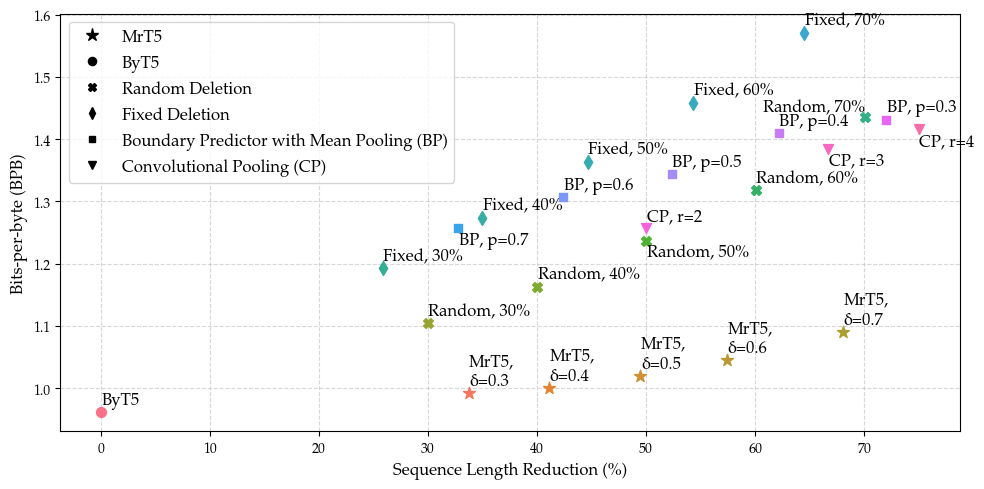

Plotting for English


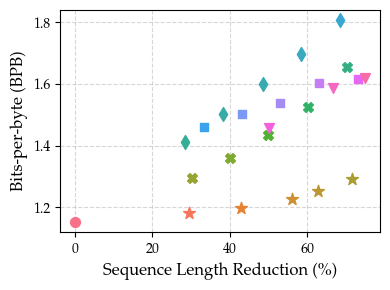

Plotting for French


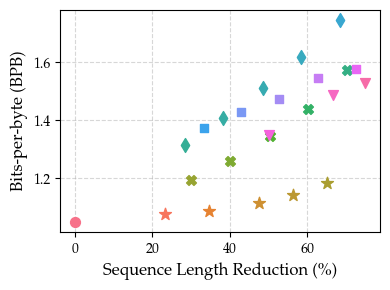

Plotting for Spanish


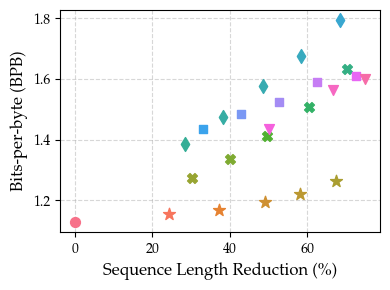

Plotting for German


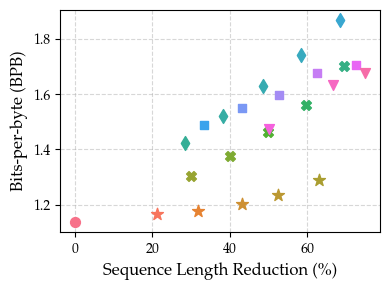

Plotting for Greek


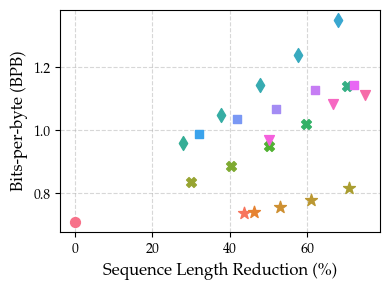

Plotting for Bulgarian


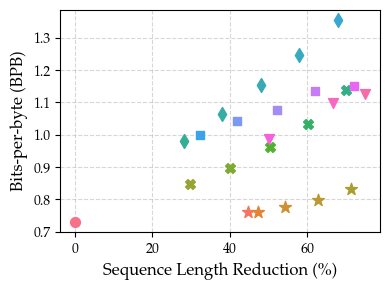

Plotting for Russian


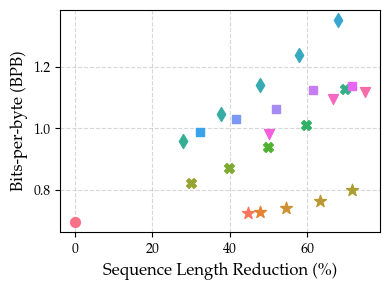

Plotting for Turkish


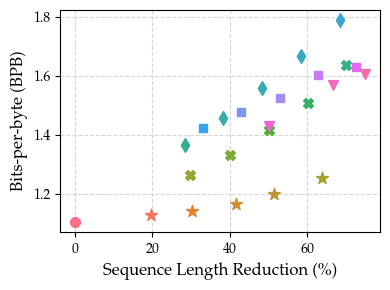

Plotting for Arabic


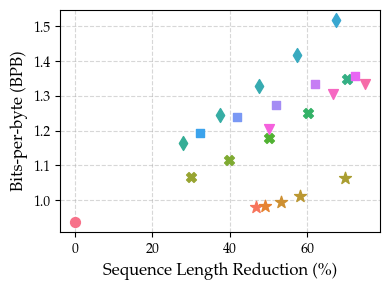

Plotting for Vietnamese


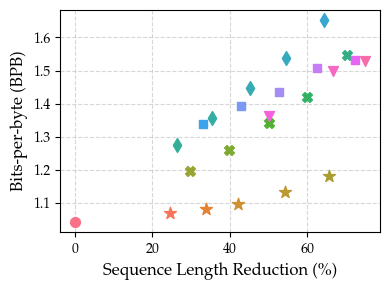

Plotting for Thai


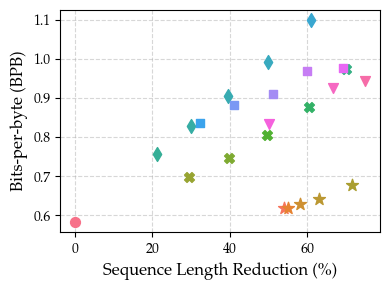

Plotting for Chinese


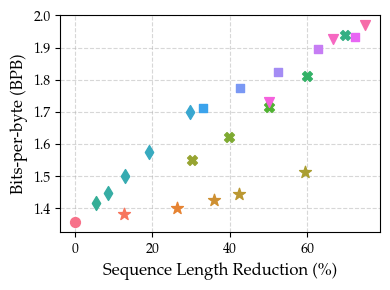

Plotting for Hindi


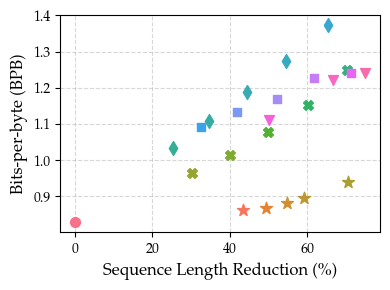

Plotting for Swahili


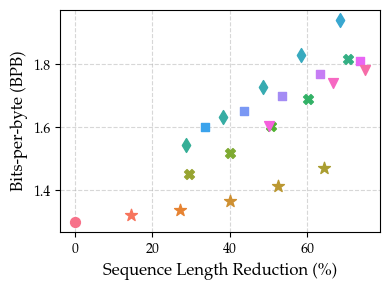

Plotting for Urdu


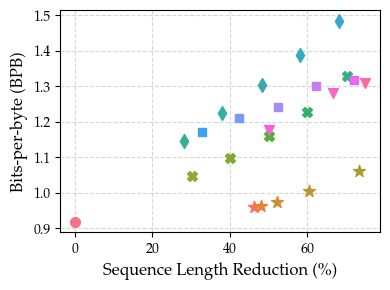

In [39]:
plot_loss_vs_deletions()

for language in SUBSET_LANGUAGES.values():
    plot_loss_vs_deletions(language)

## Per-Language Eval

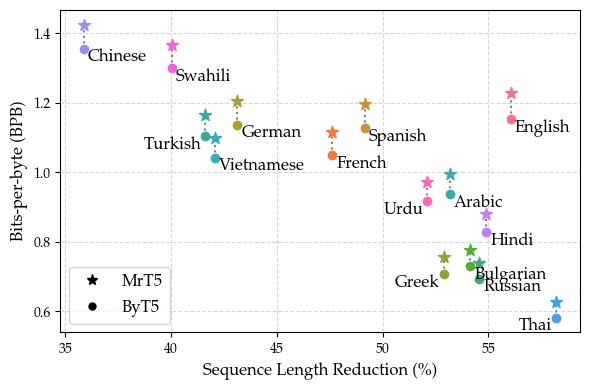

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import math
from utils import ALL_LANGUAGES, SUBSET_LANGUAGES

plt.rcParams['font.family'] = 'P052'
plt.rcParams['font.serif'] = ['Times New Roman']

def clean_loss_dataset(byt5_df, mrt5_df):
    """
    This function takes two dataframes, one containing ByT5 losses and another containing MrT5 losses, 
    and combines them into a single dataframe for analysis.
    
    Both dataframes are expected to have the same layout with the columns:
    'Language', 'Eval Cross Entropy Loss', and 'Eval Percent Deleted Tokens'.

    Parameters:
    byt5_df: The dataframe containing ByT5 losses.
    mrt5_df: The dataframe containing MrT5 losses.

    Returns:
    A combined dataframe with columns: 'Language', 'ByT5 Loss', 'MrT5 Loss', 'Seq. Len. Reduction (%)'
    """
    # Select necessary columns from both dataframes
    byt5_clean = byt5_df[['Language', 'Eval Cross Entropy Loss']].copy()
    mrt5_clean = mrt5_df[['Language', 'Eval Cross Entropy Loss', 'Eval Percent Deleted Tokens']].copy()

    # Rename columns for clarity
    byt5_clean.columns = ['Language', 'ByT5 Loss']
    mrt5_clean.columns = ['Language', 'MrT5 Loss', 'Seq. Len. Reduction (%)']

    # Merge the two dataframes on 'Language' and 'Seq. Len. Reduction (%)'
    combined_df = pd.merge(byt5_clean, mrt5_clean[['Language', 'MrT5 Loss', 'Seq. Len. Reduction (%)']], on='Language')

    # Convert Cross Entropy Losses to Bits-per-byte by multiplying with log2(e)
    log2_e = math.log2(math.e)
    combined_df['ByT5 Loss (Bits-per-byte)'] = combined_df['ByT5 Loss'] * log2_e
    combined_df['MrT5 Loss (Bits-per-byte)'] = combined_df['MrT5 Loss'] * log2_e

    return combined_df

def plot_losses_with_labels_and_colors(df, figsize=(6, 4), all_languages=False):
    """
    This function takes a dataframe as input and plots a chart showing the loss vs sequence length reduction,
    with labels and different colors for each language.
    """

    # Initialize the plot
    _, ax = plt.subplots(figsize=figsize)

    # Get a color map based on the number of unique languages
    if all_languages:
        unique_languages = ALL_LANGUAGES.values()
    else:
        unique_languages = SUBSET_LANGUAGES.values()
    colors = sns.color_palette("husl", len(unique_languages))

    # Plot data for each language
    for i, language in enumerate(unique_languages):
        subset = df[df['Language'] == language]
        color = colors[i]
        ax.scatter(subset['Seq. Len. Reduction (%)'], subset['ByT5 Loss (Bits-per-byte)'], color=color, label=f"{language} (ByT5)", marker='o', zorder=3)
        ax.scatter(subset['Seq. Len. Reduction (%)'], subset['MrT5 Loss (Bits-per-byte)'], color=color, label=f"{language} (MrT5)", marker='*', s=80, zorder=3)
        for j in range(len(subset)):
            ax.plot([subset['Seq. Len. Reduction (%)'].iloc[j], subset['Seq. Len. Reduction (%)'].iloc[j]],
                    [subset['ByT5 Loss (Bits-per-byte)'].iloc[j], subset['MrT5 Loss (Bits-per-byte)'].iloc[j]],
                    color='gray', linestyle='dotted')
            # Add label for MrT5 Loss
            if language in ['Greek', 'Thai', 'Turkish', 'Urdu']:
                ax.text(subset['Seq. Len. Reduction (%)'].iloc[j] - 0.2, subset['ByT5 Loss (Bits-per-byte)'].iloc[j],
                        language, fontsize=12, va="top", ha="right", zorder=5)
            else:
                ax.text(subset['Seq. Len. Reduction (%)'].iloc[j] + 0.2, subset['ByT5 Loss (Bits-per-byte)'].iloc[j],
                        language, fontsize=12, va="top", zorder=5)

    # Add labels and grid
    ax.set_xlabel('Sequence Length Reduction (%)', fontsize=12)
    ax.set_ylabel('Bits-per-byte (BPB)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5, zorder=-2)

    # Create a custom legend for ByT5 and MrT5
    mrt5_marker = plt.Line2D([], [], color='black', marker='*', linestyle='None', markersize=8, label='MrT5')
    byt5_marker = plt.Line2D([], [], color='black', marker='o', linestyle='None', markersize=5, label='ByT5')
    ax.legend(handles=[mrt5_marker, byt5_marker], loc='lower left', fontsize=12)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.savefig("figures/span_corruption/span_corruption_multilingual.pdf", bbox_inches='tight')
    plt.show()

# Example usage
mrt5_multilingual_df = pd.read_csv('eval_results/span_corruption_multilingual/MrT5/mrt5_span_corruption_multilingual_pi-cntrl50%_seed40_100langs.csv')
t5_multilingual_df = pd.read_csv('eval_results/span_corruption_multilingual/T5/t5_span_corruption_multilingual_seed76_100langs.csv')
multilingual_combined_df = clean_loss_dataset(t5_multilingual_df, mrt5_multilingual_df)

# plot_losses_with_labels_and_colors(multilingual_combined_df, figsize=(22, 12), all_languages=True)
plot_losses_with_labels_and_colors(multilingual_combined_df)